In [1]:
import spherical_functions as sf
import quaternion
# from scipy.special import lpmn as pl
from scipy.special import eval_legendre as pl

In [2]:
sf.error_on_bad_indices = False #Dangerous

In [106]:
from scipy.special import binom,jn,loggamma
#from scipy.special import hyp2f1 as h21
from scipy.special import eval_jacobi as jacobi

In [212]:
def wigner_d(l,m1,m2,theta):
    k=np.amin([l-m1,l-m2,l+m1,l+m2],axis=0)
    a=np.absolute(m1-m2)
    lamb=0 #lambda
    if m2>m1:
        lamb=m2-m1
    b=2*l-2*k-a
    d_mat=(-1)**lamb
    d_mat*=np.sqrt(binom(2*l-k,k+a)) #this gives array of shape l with elements choose(2l[i]-k[i], k[i]+a)
    d_mat/=np.sqrt(binom(k+b,b))
    d_mat*=np.sin(theta/2.0)**a
    d_mat*=np.cos(theta/2.0)**b
    d_mat*=jacobi(l,a,b,np.cos(theta))
    x=k<0
    d_mat[x]=0
    return d_mat        

In [220]:
l=np.arange(5000)#+1000
m1=2
m2=2

In [221]:
theta=np.pi/40
%time dm=wigner_d(l,m1,m2,theta)

CPU times: user 132 ms, sys: 2.37 ms, total: 134 ms
Wall time: 133 ms


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [222]:
%time pl0=pl(l,np.cos(theta))

CPU times: user 118 ms, sys: 2.04 ms, total: 120 ms
Wall time: 120 ms


/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


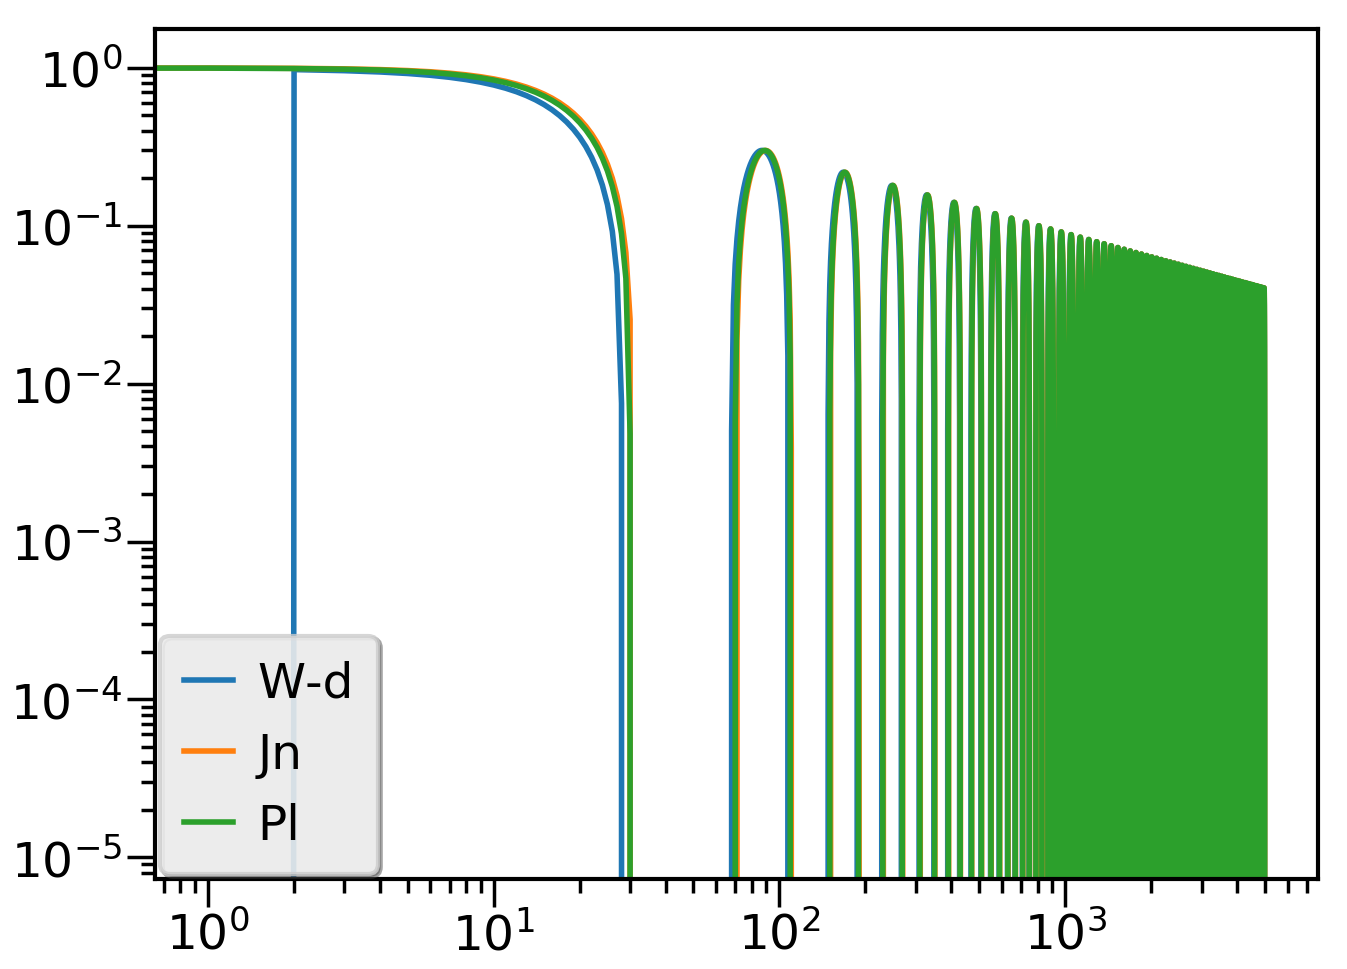

In [224]:
plot(l,dm,label='W-d')
plot(l,jn(m1-m2,l*theta),label='Jn')
plot(l,pl0,label='Pl')
xscale('log')
yscale('log')
legend()
# xlim(655,700)

/Users/Deep/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


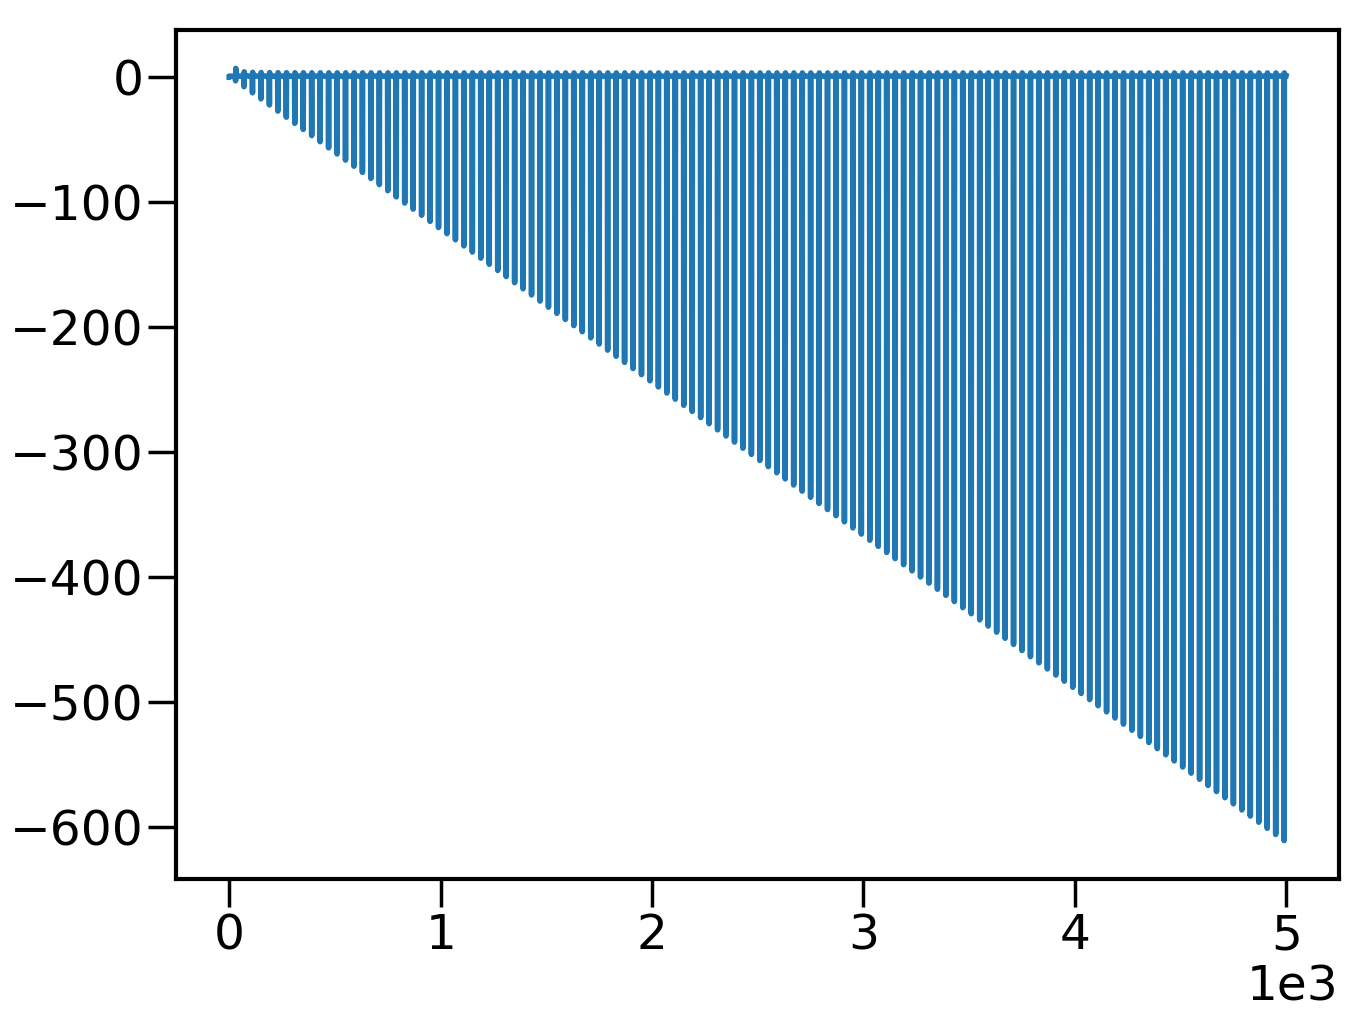

In [225]:
plot(l,dm/jn(m1-m2,l*theta))

In [226]:
from sympy.physics.wigner import wigner_3j

In [227]:
def log_factorial(n):
    return loggamma(n+1)
#     if n==0:
#         return 0
#     if n<0:
#         return np.nan
#     return n*np.log(n) -n +0.5*np.log(2*np.pi*n) + 1./12./n-1./360./n**3

In [228]:
def Wigner3j_log_vec(j_1, j_2, j_3, m_1, m_2, m_3):
    """Calculate the Wigner 3j symbol `Wigner3j(j_1,j_2,j_3,m_1,m_2,m_3)`

    This function is copied with minor modification from
    sympy.physics.Wigner, as written by Jens Rasch.

    The inputs must be integers.  (Half integer arguments are
    sacrificed so that we can use numba.)  Nonzero return quantities
    only occur when the `j`s obey the triangle inequality (any two
    must add up to be as big as or bigger than the third).

    Examples
    ========

    >>> from spherical_functions import Wigner3j
    >>> Wigner3j(2, 6, 4, 0, 0, 0)
    0.186989398002
    >>> Wigner3j(2, 6, 4, 0, 0, 1)
    0

    """
    if (m_1 + m_2 + m_3 != 0):
        return np.zeros_like(j_1)
    if ( (abs(m_2) > j_2) or (abs(m_3) > j_3) ):
        return np.zeros_like(j_1)

    a1 = j_1 + j_2 - j_3
    a2 = j_1 - j_2 + j_3
    a3 = -j_1 + j_2 + j_3

    prefid = np.ones_like(a1) # (1 if (j_1 - j_2 - m_3) % 2 == 0 else -1)
    prefid[(j_1 - j_2 - m_3+j_3*0) % 2 == 1]=-1
    
    sumres = np.zeros_like(a1,dtype='complex')
    x0=np.logical_not(np.any([a1<0 ,a2<0 , a3<0, abs(m_1) > j_1+j_2*0+j_3*0],axis=0))
    j_1=j_1[x0]
    
    m_3 = -m_3

    log_argsqrt = ( log_factorial(j_1 + j_2 - j_3) +
                log_factorial(j_1 - j_2 + j_3) +
                log_factorial(-j_1 + j_2 + j_3) +
                log_factorial(j_1 - m_1) +
                log_factorial(j_1 + m_1) +
                log_factorial(j_2 - m_2) +
                log_factorial(j_2 + m_2) +
                log_factorial(j_3 - m_3) +
                log_factorial(j_3 + m_3) ) - log_factorial(j_1 + j_2 + j_3 + 1)
    
    log_ressqrt=0.5*log_argsqrt

    imin_t=max(-j_3 + j_2 - m_1, 0)
    imin = -j_3 + j_1 + m_2
    imin[imin<imin_t]=imin_t
    
    imax_t=j_1 - m_1
    imax_t[imax_t>j_2 + m_2]=j_2 + m_2
    imax =j_1 + j_2 - j_3
    imax[imax>imax_t]=imax_t[imax>imax_t]
    
    for ii in np.arange(min(imin), max(imax) + 1):
        log_den = ( log_factorial(ii) +
                log_factorial(ii + j_3 - j_1 - m_2) +
                log_factorial(j_2 + m_2 - ii) +
                log_factorial(j_1 - ii - m_1) +
                log_factorial(ii + j_3 - j_2 + m_1) +
                log_factorial(j_1 + j_2 - j_3 - ii) )
        sgn=-1
        if (ii % 2 == 0):
            sgn=1
        sumres_ii=np.exp(log_ressqrt-log_den)*sgn
        x=ii<imin
        x*=ii>imax

        sumres_ii[x]*=0
        sumres[x0]+=sumres_ii
    
    return sumres * prefid #ressqrt taken inside sumres calc

In [242]:
def Wigner3j_log(j_1, j_2, j_3, m_1, m_2, m_3):
    """Calculate the Wigner 3j symbol `Wigner3j(j_1,j_2,j_3,m_1,m_2,m_3)`

    This function is copied with minor modification from
    sympy.physics.Wigner, as written by Jens Rasch.

    The inputs must be integers.  (Half integer arguments are
    sacrificed so that we can use numba.)  Nonzero return quantities
    only occur when the `j`s obey the triangle inequality (any two
    must add up to be as big as or bigger than the third).

    Examples
    ========

    >>> from spherical_functions import Wigner3j
    >>> Wigner3j(2, 6, 4, 0, 0, 0)
    0.186989398002
    >>> Wigner3j(2, 6, 4, 0, 0, 1)
    0

    """
    
#     log_factorial=lambda n: loggamma(n+1)
    
    if (m_1 + m_2 + m_3 != 0):
        return 0
    if ( (abs(m_1) > j_1) or (abs(m_2) > j_2) or (abs(m_3) > j_3) ):
        return 0
    prefid = (1 if (j_1 - j_2 - m_3) % 2 == 0 else -1)
    m_3 = -m_3
    a1 = j_1 + j_2 - j_3
    a2 = j_1 - j_2 + j_3
    a3 = -j_1 + j_2 + j_3
    if (a1 < 0) or a2<0 or a3<0:
        return 0

    log_argsqrt = ( log_factorial(j_1 + j_2 - j_3) +
                log_factorial(j_1 - j_2 + j_3) +
                log_factorial(-j_1 + j_2 + j_3) +
                log_factorial(j_1 - m_1) +
                log_factorial(j_1 + m_1) +
                log_factorial(j_2 - m_2) +
                log_factorial(j_2 + m_2) +
                log_factorial(j_3 - m_3) +
                log_factorial(j_3 + m_3) ) - log_factorial(j_1 + j_2 + j_3 + 1)
    
    log_ressqrt=0.5*log_argsqrt

    imin = max(-j_3 + j_1 + m_2, max(-j_3 + j_2 - m_1, 0)) 
    imax = min(j_2 + m_2, min(j_1 - m_1, j_1 + j_2 - j_3))

    sumres = 0.0
    ii=np.arange(imin, imax + 1)
    
    log_den = ( log_factorial(ii) +
                log_factorial(ii + j_3 - j_1 - m_2) +
                log_factorial(j_2 + m_2 - ii) +
                log_factorial(j_1 - ii - m_1) +
                log_factorial(ii + j_3 - j_2 + m_1) +
                log_factorial(j_1 + j_2 - j_3 - ii) )
    sgn=np.ones_like(ii) #-1
    sgn[ii % 2 == 1]=-1
    sumres +=np.sum(np.exp(log_ressqrt-log_den)*sgn)  #1.0 / den
    return sumres * prefid #ressqrt taken inside sumres calc

In [243]:
j1=100#np.arange(10)
j2=100
j3=0
m1=0
m2=0
m3=0

%timeit el2=Wigner3j_log(j1,j2,j3,m1,m2,m3)

j1_nd=np.arange(1000)#np.array([j1,1001,1002])#np.arange(5,7)
%time el_nd=Wigner3j_log_vec(j1_nd,j2,j3,m1,m2,m3)
#%time el_nd=Wigner3j_log_vec(np.array(j1),j2,j3,m1,m2,m3)

el_nd[j1],el2

10000 loops, best of 3: 67.7 µs per loop
CPU times: user 523 µs, sys: 111 µs, total: 634 µs
Wall time: 567 µs


((0.070534561585859329+0j), (0.070534561585859329+0j))

In [244]:
%time el3=wigner_3j(j1,j2,j3,m1,m2,m3).evalf()

CPU times: user 543 µs, sys: 1e+03 ns, total: 544 µs
Wall time: 552 µs


In [241]:
el2,el3.evalf()

((0.070534561585859329+0j), 0.0705345615858598)